<img src="https://pbs.twimg.com/media/E_4gSkjVQAIXhaU.jpg" width=600 height=300>

# LIBRERÍAS

In [46]:
import os
import pandas as pd
import numpy as np
import datetime as dt

import missingno as msno
from collections import Counter
from sklearn.impute import KNNImputer

from pyod.models.iforest import IForest
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from preprocesamiento.funciones_preprocesamiento import *

In [47]:
# Se crea el directorio donde se guardarán los datos limpios
path_clean_data = os.path.join('Datos','Limpios')
if not os.path.exists(path_clean_data):
    os.makedirs(path_clean_data)

# INGESTA DE DATOS

In [48]:
# Path de datos originales
path_originales = os.path.join('Datos','Originales')

# Cargamos los datasets
df1 = leer_excel(path_originales, 'df_sabi_modif_1.xlsx')
df2 = leer_excel(path_originales, 'df_sabi_modif_2_new.xlsx')
df2_2 = leer_excel(path_originales, 'df_sabi_parte3.xlsx')
df3 = leer_excel(path_originales, 'df_dealroom_modif.xlsx')

* df1 --> datos legales de la empresa y porcentaje de adquisición; 0 missings
* df2 --> NIF, año, número de empleados y 38 variables contables (Balance y Cuenta de Pérdidas y Ganancias; algunas en miles y otras en porcentaje); 2308 missings en total, 94 de ellos en la columna del número de empleados
* df3 --> NIF, perfil de Dealroom y web (scraping), sector (tagline: qué hace la empresa,NLP ; revenue_models: sector), datos de rondas de financiación (fecha de primera y última, cantidad total y de la última, tipo de la última, cuántas rondas), número de empleados según Dealroom (pocos datos; contrastar con el del sabi), fase de la startup (ownerships y growth stage), b2b_b2c, valuation_2022 (pocos datos); 1393 missings en total, 305 de ellos en la columna del número de empleados y 352 de ellos en la de la valoración en 2022

* 412 instancias en df1 y df3, 824 instancias en df2 (datos para 2020 y 2021 de esas 412 startups)

# PREPROCESAMIENTO INICIAL

## DF SABI 1

In [49]:
df1.isna().sum() # no hay missings en este dataframe

Codigo_NIF                    0
Nombre_sabi                   0
Localidad                     0
Fecha constitucion            0
Codigo consolidacion          0
Codigo primario CNAE 2009     0
Forma juridica                0
Forma juridica detallada      0
Estado                        0
Estado detallado              0
Capital social mil EUR        0
Free capital mil EUR          0
Porcentaje_adquisicion_cat    0
dtype: int64

In [50]:
df1['Fecha constitucion']=pd.to_datetime(df1['Fecha constitucion'], format='%Y/%m/%d')

In [51]:
print(f"{df2.shape[0]} filas y {df2.shape[1]} columnas en df2.")

print(f'{df2.isna().sum().sum()} missings en total.')
print(f'{df2[["Codigo_NIF"]].isna().sum().sum()} missings en la columna del NIF.')
print(f'{df2[["year"]].isna().sum().sum()} missings en la columna del año.')
print(f'{df2[["Número empleados"]].isna().sum().sum()} missings en la columna del número de empleados.')

df2.head()

824 filas y 51 columnas en df2.
2820 missings en total.
0 missings en la columna del NIF.
0 missings en la columna del año.
94 missings en la columna del número de empleados.


,Codigo_NIF,year,Acreedores a L. P. mil EUR,Acreedores comerciales mil EUR,Activo circulante mil EUR,Apalancamiento (%) %,Capital suscrito mil EUR,Cash flow mil EUR,Deudas financieras mil EUR,EBITDA mil EUR,...,Coeficiente de solvencia (%) %,Costes de los trabajadores / Ingresos de explotación (%) %,Deudores mil EUR,Dotaciones para amortiz. de inmovil. mil EUR,EBIT mil EUR,Gastos financieros y gastos asimilados mil EUR,Impuestos sobre sociedades mil EUR,Rentabilidad sobre capital empleado (%) %,Rentabilidad sobre el activo total (%) %,Rentabilidad sobre recursos propios (%) %
0,A78053147,2021.0,15314.000,339928.000,1032835.000,147.861,2000.0,3589.000,NaN,6182.000,...,12.392,7.645,751524.000,2743.000,3439.000,3210.000,279.0,1.192,0.095,0.767
1,A78053147,2020.0,16336.000,346970.000,931984.000,122.989,2000.0,128101.000,NaN,99163.000,...,14.058,7.513,653291.000,10189.000,88974.000,5575.000,21547.0,44.601,13.444,95.633
2,B75103515,2021.0,61152.908,19954.260,152330.720,1141.461,20500.0,-5899.978,29685.498,-5011.881,...,4.777,8.111,70254.306,3270.684,-8282.565,983.042,NaN,-11.847,-5.504,-115.237
3,B75103515,2020.0,83608.494,12554.314,107903.655,-598.358,10000.0,-13014.985,19944.946,-12410.040,...,-14.146,15.277,49474.365,3110.304,-15520.344,692.911,NaN,-23.275,-13.181,93.176
4,B95864310,2021.0,17489.000,11920.000,55895.000,115.514,7515.0,92.000,8380.000,1974.000,...,22.183,20.928,7946.000,2386.000,-412.000,2098.000,-250.0,-1.085,-2.459,-11.086


## DF SABI 2 (variables financieras)

### Union y eliminacion de instancias

Se juntan el df2 y el df2_2, que contienen ambos datos financieros, pero distintas variables


In [52]:
df2 = df2.merge(df2_2, on=['Codigo_NIF', 'year'], how='outer') # por las claves primarias: "Codigo_NIF" y "year"

Se quitan las instancias de 2020 para las empresas que se han creado a finales de 2020 o en 2021


In [53]:
df2 = df2[df2.isna().mean(axis=1)<0.5]

Hay algunos NaNs camuflados como 'n.s.', los convertiremos a NaNs


In [54]:
print(f"n.s.: {df2[df2=='n.s.'].count().sum()}")

n.s.: 1255


In [55]:
df2 = df2.replace('n.s.', np.nan)

In [56]:
print(f"n.s.: {df2[df2=='n.s.'].count().sum()}")

n.s.: 0


In [57]:
df2.shape

(815, 76)

### Colinealidades entre varibles financieras

<img src="https://www.gmconsulting.pro/wp-content/uploads/2014/12/Equilibrio-financiero.jpg" width=600 height=400>
<img src="https://1.bp.blogspot.com/-6S5kz2O5zS8/YEeDLSxR_aI/AAAAAAAAHbI/kEV9SEur0O0yGNnTzMi_NLCgL_abgOS4ACLcBGAsYHQ/w640-h612/ejercicio.png" width=425 height=400>

In [58]:
# COLINEALIDADES ENTRE LAS VARIABLES FINANCIERAS

# BALANCE

# Activo no corriente
df2[['Inmovilizado mil EUR', 'Inmovilizado inmaterial mil EUR', 'Inmovilizado material mil EUR', 'Otros activos fijos mil EUR']].isna().sum()
# Cuadran bien, por lo que nos quedamos con la columna principal, que es la que tiene menos missings

# Activo corriente
df2[['Activo circulante mil EUR', 'Existencias mil EUR', 'Deudores mil EUR', 'Otros activos líquidos mil EUR']].isna().sum()
# Cuadran bien, por lo que nos quedamos con la columna principal, que es la que tiene menos missings

# Total activo
(df2['Total activo mil EUR'] == df2['Inmovilizado mil EUR'] + df2['Activo circulante mil EUR']).value_counts()
# coinciden (excepto las 8 que tienen missings siempre)

# Patrimonio neto
(df2['Fondos propios mil EUR'] == (df2['Capital suscrito mil EUR'] + df2['Otros fondos propios mil EUR'])).value_counts()
# coinciden (excepto las 8 que tienen missings siempre)

# Pasivo no corriente
df2[['Pasivo fijo mil EUR', 'Otros pasivos fijos mil EUR', 'Acreedores a L. P. mil EUR']].isna().sum()
# Cuadran bien, por lo que nos quedamos con la columna principal, que es la que tiene menos missings

# Pasivo corriente
df2[['Pasivo líquido mil EUR', 'Deudas financieras mil EUR', 'Acreedores comerciales mil EUR', 'Otros pasivos líquidos mil EUR']].isna().sum()
# Cuadran bien, por lo que nos quedamos con la columna principal, que es la que tiene menos missings

# Total pasivo y patrimonio neto
df2[['Total pasivo y capital propio mil EUR', 'Fondos propios mil EUR', 'Pasivo fijo mil EUR', 'Pasivo líquido mil EUR']].isna().sum()
# Cuadran bien, por lo que nos quedamos con la columna principal, que no tiene missings

# Comprobación de la corrección del balance
(df2['Total activo mil EUR'].round() == df2['Total pasivo y capital propio mil EUR'].round()).value_counts()
# El balance cuadra a la perfección

True    815
dtype: int64

In [59]:
# Missings en las variables principales
vars_balance = ['Inmovilizado mil EUR', 'Activo circulante mil EUR', 'Total activo mil EUR', \
                    'Fondos propios mil EUR', 'Pasivo fijo mil EUR', 'Pasivo líquido mil EUR', \
                    'Total pasivo y capital propio mil EUR']
df2[vars_balance].isna().sum()

Inmovilizado mil EUR                      24
Activo circulante mil EUR                  1
Total activo mil EUR                       0
Fondos propios mil EUR                     0
Pasivo fijo mil EUR                      176
Pasivo líquido mil EUR                     4
Total pasivo y capital propio mil EUR      0
dtype: int64

### Imputación de variables financieras según reglas financieras

In [60]:
# IMPUTACIONES (I): Activo

print(df2[['Total activo mil EUR', 'Inmovilizado mil EUR', 'Activo circulante mil EUR']].isna().sum())

# Hay algunos missings, los rellenamos según las reglas contables:
df2['Inmovilizado mil EUR'] = df2['Inmovilizado mil EUR'].fillna(df2['Total activo mil EUR'] - df2['Activo circulante mil EUR'])
df2['Activo circulante mil EUR'] = df2['Activo circulante mil EUR'].fillna(df2['Total activo mil EUR'] - df2['Inmovilizado mil EUR'])

print(df2[['Total activo mil EUR', 'Inmovilizado mil EUR', 'Activo circulante mil EUR']].isna().sum())

# Missings imputados según las reglas contables

Total activo mil EUR          0
Inmovilizado mil EUR         24
Activo circulante mil EUR     1
dtype: int64
Total activo mil EUR         0
Inmovilizado mil EUR         0
Activo circulante mil EUR    0
dtype: int64


In [61]:
# IMPUTACIONES (II): Pasivo

print(df2[['Total pasivo y capital propio mil EUR', 'Fondos propios mil EUR', 'Pasivo fijo mil EUR', 'Pasivo líquido mil EUR']].isna().sum())

# Hay algunos missings, los rellenamos según las reglas contables:
df2['Pasivo fijo mil EUR'] = df2['Pasivo fijo mil EUR'].fillna(df2['Total pasivo y capital propio mil EUR'] - df2['Fondos propios mil EUR'] - df2['Pasivo líquido mil EUR'])
df2['Pasivo líquido mil EUR'] = df2['Pasivo líquido mil EUR'].fillna(df2['Total pasivo y capital propio mil EUR'] - df2['Fondos propios mil EUR'] - df2['Pasivo fijo mil EUR'])

print(df2[['Total pasivo y capital propio mil EUR', 'Fondos propios mil EUR', 'Pasivo fijo mil EUR', 'Pasivo líquido mil EUR']].isna().sum())

# Quedan 2 missings en cada columna que tenía missings, pero no se puede imputar nada más
# esas instancias son:
display(df2[df2['Pasivo líquido mil EUR'].isna()][['Total pasivo y capital propio mil EUR', 'Fondos propios mil EUR', 'Pasivo fijo mil EUR', 'Pasivo líquido mil EUR']])

# Se trata de empresas que no tienen pasivo fijo ni pasivo líquido, por lo que los NaNs se imputan como 0s

df2['Pasivo fijo mil EUR'] = df2['Pasivo fijo mil EUR'].fillna(0)
df2['Pasivo líquido mil EUR'] = df2['Pasivo líquido mil EUR'].fillna(0)

print(df2[['Total pasivo y capital propio mil EUR', 'Fondos propios mil EUR', 'Pasivo fijo mil EUR', 'Pasivo líquido mil EUR']].isna().sum())

# Missings imputados según las reglas contables

Total pasivo y capital propio mil EUR      0
Fondos propios mil EUR                     0
Pasivo fijo mil EUR                      176
Pasivo líquido mil EUR                     4
dtype: int64
Total pasivo y capital propio mil EUR    0
Fondos propios mil EUR                   0
Pasivo fijo mil EUR                      2
Pasivo líquido mil EUR                   2
dtype: int64


,Total pasivo y capital propio mil EUR,Fondos propios mil EUR,Pasivo fijo mil EUR,Pasivo líquido mil EUR
260,2250.00000,2250.00000,NaN,NaN
822,116.87972,116.87972,NaN,NaN


Total pasivo y capital propio mil EUR    0
Fondos propios mil EUR                   0
Pasivo fijo mil EUR                      0
Pasivo líquido mil EUR                   0
dtype: int64


In [62]:
# IMPUTACIONES (III): Decimales en el Activo

for i, row in df2.iterrows():
    if row['Total activo mil EUR'] != row['Inmovilizado mil EUR'] + row['Activo circulante mil EUR']:
        print(row['Total activo mil EUR'])
        print(row['Inmovilizado mil EUR'] + row['Activo circulante mil EUR'])
        break

# Las instancias que no coinciden no coindicen por un problema de decimales, por lo que se considera que son equivalentes
df2['Total activo mil EUR'] = df2['Inmovilizado mil EUR'] + df2['Activo circulante mil EUR']
print(df2['Total activo mil EUR'].isna().sum())
# 0 missings

24695.242
24695.242000000002
0


In [63]:
# IMPUTACIONES (IV): Decimales en el Patrimonio Neto

for i, row in df2.iterrows():
    if row['Fondos propios mil EUR'] != row['Capital suscrito mil EUR'] + row['Otros fondos propios mil EUR']:
        print(row['Fondos propios mil EUR'])
        print(row['Capital suscrito mil EUR'] + row['Otros fondos propios mil EUR'])
        break

# de nuevo es un problema de decimales, por lo que se considera que son iguales
df2['Fondos propios mil EUR'] = df2['Capital suscrito mil EUR'] + df2['Otros fondos propios mil EUR']
print(df2['Fondos propios mil EUR'].isna().sum())
# 0 missings

7958.076
7958.075999999999
0


### Corrección de variables

In [64]:
# 1. Fondo de maniobra = Activo circulante - Pasivo líquido
(df2['Fondo de maniobra mil EUR'].round() == (df2['Activo circulante mil EUR'] - df2['Pasivo líquido mil EUR']).round()).value_counts()
display(df2[['Fondo de maniobra mil EUR', 'Activo circulante mil EUR', 'Pasivo líquido mil EUR']].head(3))
# No cuadra en la mayoría de los casos, por lo que reescribiremos esa variable según las reglas contables

df2['Fondo de maniobra mil EUR'] = df2['Activo circulante mil EUR'] - df2['Pasivo líquido mil EUR']

print(df2['Fondo de maniobra mil EUR'].isna().sum())
# 0 missings

,Fondo de maniobra mil EUR,Activo circulante mil EUR,Pasivo líquido mil EUR
0,411596.000,1032835.00,820050.000
1,306321.000,931984.00,712086.000
2,85654.461,152330.72,97480.271


0


### Selección de variables

In [65]:
# CUENTA DE PÉRDIDAS Y GANANCIAS

# A: Resultado de explotación = Ingresos de explotación - Gastos de explotación
# B: Resultado financiero = Ingresos financieros - Gastos financieros
# C: Resultado ordinario antes de impuestos = Resultado de explotación (A) + Resultado financiero (B)
# D: Resultado del ejercicio = Resultado ordinario antes de impuestos (C) - Impuesto de sociedades

# Variables clave:
vars_perd_ganancias = ['Resultado Explotación mil EUR', 'Resultado financiero mil EUR',
                         'Resultado del Ejercicio mil EUR', 'Costes de los trabajadores / Ingresos de explotación (%) %',
                         'Tesorería mil EUR', 'Cash flow mil EUR', 'Período de cobro (días) días',
                         'Valor agregado mil EUR']
df2[vars_perd_ganancias].isna().sum()
# El Resultado ordinario antes de impuestos no se incluye porque sería redundante

# Cash flow mil EUR --> estado de flujos de efectivo
# Período de cobro (días) días --> cantidad de tiempo que una empresa tarda en recibir el pago de sus facturas
# Valor agregado mil EUR --> riqueza generada por la startup

Resultado Explotación mil EUR                                  0
Resultado financiero mil EUR                                   0
Resultado del Ejercicio mil EUR                                0
Costes de los trabajadores / Ingresos de explotación (%) %    24
Tesorería mil EUR                                             23
Cash flow mil EUR                                              0
Período de cobro (días) días                                  24
Valor agregado mil EUR                                         0
dtype: int64

In [66]:
# Ratios ya calculados
vars_ratios = df2.columns[df2.columns.str.contains('%')] # ratios ya calculados
df2[vars_ratios].isna().sum()
# pocos missings, se imputarán con KNN

Apalancamiento (%) %                                            0
Endeudamiento (%) %                                             0
Margen de beneficio (%) %                                      24
Ratio de liquidez %                                             4
Ratio de solvencia %                                            4
Rentabilidad económica (%) %                                    0
Rentabilidad financiera (%) %                                   0
Rotación de activos netos %                                     0
Rotación de las existencias %                                 425
Coeficiente de solvencia (%) %                                  0
Costes de los trabajadores / Ingresos de explotación (%) %     24
Rentabilidad sobre capital empleado (%) %                       0
Rentabilidad sobre el activo total (%) %                        0
Rentabilidad sobre recursos propios (%) %                       0
Liquidez general %                                              4
Ratio de c

In [67]:
# Otras variables seleccionadas necesarias para calcular nuevas variables o ejecucion de alguna tarea del reto
vars_otros = ['EBITDA mil EUR', 'EBIT mil EUR', 'Fondo de maniobra mil EUR', 'Impuestos sobre sociedades mil EUR', 'Dotaciones para amortiz. de inmovil. mil EUR',
                'Deudas financieras mil EUR', 'Importe neto Cifra de Ventas mil EUR', 'Existencias mil EUR', 'Acreedores comerciales mil EUR']

In [68]:
# Variables identificativas de la empresa 
vars_identificativas = ['Codigo_NIF', 'year', 'Número empleados']

In [69]:
vars = []
vars.extend(vars_identificativas)
vars.extend(vars_balance)
vars.extend(vars_perd_ganancias)
vars.extend(vars_ratios)
vars.extend(vars_otros)
df2_final = df2[vars]

In [70]:
df2_final.shape

(815, 44)

In [71]:
df2_final.columns

Index(['Codigo_NIF', 'year', 'Número empleados', 'Inmovilizado mil EUR',
       'Activo circulante mil EUR', 'Total activo mil EUR',
       'Fondos propios mil EUR', 'Pasivo fijo mil EUR',
       'Pasivo líquido mil EUR', 'Total pasivo y capital propio mil EUR',
       'Resultado Explotación mil EUR', 'Resultado financiero mil EUR',
       'Resultado del Ejercicio mil EUR',
       'Costes de los trabajadores / Ingresos de explotación (%) %',
       'Tesorería mil EUR', 'Cash flow mil EUR',
       'Período de cobro (días) días', 'Valor agregado mil EUR',
       'Apalancamiento (%) %', 'Endeudamiento (%) %',
       'Margen de beneficio (%) %', 'Ratio de liquidez %',
       'Ratio de solvencia %', 'Rentabilidad económica (%) %',
       'Rentabilidad financiera (%) %', 'Rotación de activos netos %',
       'Rotación de las existencias %', 'Coeficiente de solvencia (%) %',
       'Costes de los trabajadores / Ingresos de explotación (%) %',
       'Rentabilidad sobre capital empleado (%) %'

In [72]:
# Estos missings se imputaran con KNN
df2_final.isna().mean(axis=0).sort_values(ascending=False)

Rotación de las existencias %                                 0.521472
Existencias mil EUR                                           0.521472
Deudas financieras mil EUR                                    0.479755
Acreedores comerciales mil EUR                                0.306748
Ratios de autonomía financiera a medio y largo plazo %        0.215951
Impuestos sobre sociedades mil EUR                            0.208589
Ratio de cobertura de intereses %                             0.175460
Dotaciones para amortiz. de inmovil. mil EUR                  0.109202
Número empleados                                              0.104294
Importe neto Cifra de Ventas mil EUR                          0.073620
Margen de beneficio (%) %                                     0.029448
Costes de los trabajadores / Ingresos de explotación (%) %    0.029448
Costes de los trabajadores / Ingresos de explotación (%) %    0.029448
Período de cobro (días) días                                  0.029448
Tesore

## DF 3 (_Dealroom_)

In [73]:
df3.isna().sum().sort_values(ascending=False)

valuation_2022          352
n_empleados_dealroom    305
last_funding            216
revenue_models          184
last_round               70
ownerships               67
tagline                  56
first_funding_date       48
last_funding_date        48
total_funding            31
b2b_b2c                  15
growth_stage              1
name_dealroom             0
total_rounds              0
website                   0
profile_url               0
company_status            0
Codigo_NIF                0
dtype: int64

Si no hay rondas de financiación, no van a tener fechas de financiación ni valor de la financiación (first_funding_date, last_funding_date, last_funding, last_round, total_funding).


Hay 48 que no han tenido rondas de financiacion, el numero coincide con el número de missings de las fechas.

In [74]:
df3.groupby("total_rounds").size()

total_rounds
0      48
1      39
2      31
3     110
4      78
5      33
6      24
7      18
8      11
9       5
10      3
11      2
12      2
14      2
16      1
17      2
18      1
21      1
24      1
dtype: int64

Inventamos una fecha para las instancias que tienen missings : 1 de enero de 1900 y corregimos el formato

In [75]:
# first funding date

df3['first_funding_date']=df3['first_funding_date'].fillna("jan/1900")

for index, row in df3.iterrows():
    try:
        df3['first_funding_date'][index]=pd.to_datetime(row['first_funding_date'], format='%b/%Y')
    except: df3['first_funding_date'][index]=pd.to_datetime(row['first_funding_date'], format='%Y')

# last funding date

df3['last_funding_date']=df3['last_funding_date'].fillna("jan/1900")

for index, row in df3.iterrows():
    try:
        df3['last_funding_date'][index]=pd.to_datetime(row['last_funding_date'], format='%b/%Y')
    except: df3['last_funding_date'][index]=pd.to_datetime(row['last_funding_date'], format='%Y')

C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\1334530475.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['first_funding_date'][index]=pd.to_datetime(row['first_funding_date'], format='%b/%Y')
C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\1334530475.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  except: df3['first_funding_date'][index]=pd.to_datetime(row['first_funding_date'], format='%Y')
C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\1334530475.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

Las instancias cuya fecha de financiación sea 1900/1/1 no tienen rondas de financiación y las rellenamos con el valor "sin ronda".

In [76]:
df3.loc[df3['first_funding_date'] == dt.datetime(1900,1,1), 'last_round'] = df3[df3['first_funding_date'] == dt.datetime(1900,1,1)]['last_round'].fillna("sin ronda")

In [77]:
df3[df3['total_rounds']==0]['total_funding'].mean() # teniendo en cuenta esto, los missing de total funding son datos que no se han recogido

0.0

En las instancias donde total_funding es 0, el valor de la columna last_funding también es 0.


Todas las empresas que tienen total_funding=0 son las que tampoco tienen ronda de financiación.

In [78]:
df3[df3['total_funding']==0].shape 
df3.loc[df3['total_funding'] == 0, 'last_funding'] = df3[df3['total_funding'] == 0]['last_funding'].fillna(0)

------------------------------------------------------------------------------------------------------------------------------------------

## ANÁLISIS DE LA VARIABLE DEL NÚMERO DE EMPLEADOS **después de agrupar**

In [79]:
emp_años = df2.pivot(index='Codigo_NIF', columns='year', values='Número empleados').reset_index()
empleados = pd.merge(emp_años, df3[['Codigo_NIF', 'n_empleados_dealroom']], on='Codigo_NIF')
empleados.head()

,Codigo_NIF,2020.0,2021.0,n_empleados_dealroom
0,A48464788,61.0,69.0,46.0
1,A48500052,6.0,6.0,NaN
2,A78053147,968.0,919.0,NaN
3,A95291613,34.0,32.0,52.0
4,A95363859,51.0,61.0,246.0


In [80]:
x  = len(empleados[(empleados[2020].isna()) & (empleados[2021].isna()) & (empleados['n_empleados_dealroom'].isna())]) 
print(f'{x} instancias que tienen missings en las columnas del número de empleados de 2020, 2021 y dealroom.')

z  = len(empleados[~(empleados[2020].isna()) & (empleados[2021].isna())]) 
print(f'{z} instancias que se pueden cruzar entre 2020 y 2021.')

y = len(empleados[~(empleados['n_empleados_dealroom'].isna()) & (empleados[2021].isna())])
print(f'{y} instancias que se pueden cruzar entre 2021 y dealroom.')

26 instancias que tienen missings en las columnas del número de empleados de 2020, 2021 y dealroom.
8 instancias que se pueden cruzar entre 2020 y 2021.
5 instancias que se pueden cruzar entre 2021 y dealroom.


Aunque se puedan cruzar los datos, no se garantiza que tengan mucha fiablidad puesto que las correlaciones entre los datos de SABI y _Dealroom_ no son muy elevadas.

In [81]:
empleados.corr()

,2020.0,2021.0,n_empleados_dealroom
2020.0,1.000000,0.990929,0.595516
2021.0,0.990929,1.000000,0.564381
n_empleados_dealroom,0.595516,0.564381,1.000000


------------------------------------------------

# AGRUPAR _DATAFRAMES_

### Agrupación y selección de la variable del número de empleados

In [82]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(412, 13)
(815, 76)
(412, 18)


In [83]:
dftot = df1.merge(df3, on="Codigo_NIF", how="outer")
dftot = dftot.merge(df2_final, on="Codigo_NIF", how="outer")
print(dftot.shape)

(815, 73)


In [84]:
dftot.isna().mean().sort_values(ascending=False)

valuation_2022                           0.852761
n_empleados_dealroom                     0.738650
Existencias mil EUR                      0.521472
Rotación de las existencias %            0.521472
Deudas financieras mil EUR               0.479755
                                           ...   
Nombre_sabi                              0.000000
Pasivo líquido mil EUR                   0.000000
Total pasivo y capital propio mil EUR    0.000000
Resultado Explotación mil EUR            0.000000
Pasivo fijo mil EUR                      0.000000
Length: 73, dtype: float64

In [85]:
# Hay dos columnas con el numero de empleados así que nos quedamos con el que menos missings tenga, en este caso la denominada n_empleados (la del SABI)
dftot = dftot.drop(columns="n_empleados_dealroom")

## ANÁLISIS DE LA VARIABLE DEL NÚMERO DE EMPLEADOS

In [86]:
# Tengo una variable "n_empleados"
# Y una variable "growth_stage"
# Quiero imputar la columna "n_empleados" según la media de la columna "n_empleados" de las empresas que estén en el mismo "growth_stage"

# Media de empleados por growth_stage
print(dftot.groupby('growth_stage')['Número empleados'].mean())

dftot['Número empleados'] = dftot.groupby('growth_stage')['Número empleados'].transform(lambda x: x.fillna(x.mean()))

# Se pone el Codigo_NIF como índice
dftot.set_index('Codigo_NIF', inplace=True)

growth_stage
early growth    20.866379
late growth     44.894737
seed             5.943052
Name: Número empleados, dtype: float64


In [87]:
dftot['Número empleados'].isna().sum()

2

In [88]:
dftot[dftot['Número empleados'].isna()]

,Nombre_sabi,Localidad,Fecha constitucion,Codigo consolidacion,Codigo primario CNAE 2009,Forma juridica,Forma juridica detallada,Estado,Estado detallado,Capital social mil EUR,...,Ratios de autonomía financiera a medio y largo plazo %,EBITDA mil EUR,EBIT mil EUR,Fondo de maniobra mil EUR,Impuestos sobre sociedades mil EUR,Dotaciones para amortiz. de inmovil. mil EUR,Deudas financieras mil EUR,Importe neto Cifra de Ventas mil EUR,Existencias mil EUR,Acreedores comerciales mil EUR
Codigo_NIF,,,,,,,,,,,,,,,,,,,,,
B95285292,LORKE SYSTEMS SL,VITORIA-GASTEIZ,2003-10-30,U1,4673,Sociedad limitada,Sociedad limitada,Activa,Activa,3.01,...,1.009,27.99325,17.55355,133.84537,2.79427,10.43970,NaN,943.58985,NaN,255.01936
B95285292,LORKE SYSTEMS SL,VITORIA-GASTEIZ,2003-10-30,U1,4673,Sociedad limitada,Sociedad limitada,Activa,Activa,3.01,...,0.773,23.94066,13.43074,121.34612,1.79337,10.50992,NaN,666.43190,NaN,84.12117


In [89]:
# En Linkedin indican que tienen entre 11 y 50 empleados, de modo que se imputa con 30
dftot.loc[dftot['Número empleados'].isna(), 'Número empleados'] = 30

In [90]:
dftot['Número empleados'].isna().sum() # no quedan missings en el número de empleados

0

In [91]:
dftot = dftot.loc[:,~dftot.columns.duplicated()]

In [92]:
dftot.to_csv("./Datos/Limpios/para_outliers.csv", index=False)

# OUTLIERS

# CREACIÓN DE VARIABLES

In [93]:
# RATIOS FINANCIEROS ADICIONALES

# Ratios con la deuda
dftot['ratio_deuda_ebitda'] = dftot['Deudas financieras mil EUR'] / dftot['EBITDA mil EUR']
dftot['ratio_deuda_activos'] = dftot['Deudas financieras mil EUR'] / dftot['Total activo mil EUR']
dftot['ratio_deuda_patrimonio'] = dftot['Deudas financieras mil EUR'] / dftot['Fondos propios mil EUR']

# Ratios con el EBITDA
dftot['ratio_ebitda_activos'] = dftot['EBITDA mil EUR'] / dftot['Total activo mil EUR']
dftot['ratio_ebitda_patrimonio'] = dftot['EBITDA mil EUR'] / dftot['Fondos propios mil EUR']

# Ratios con las ventas
dftot['ratio_ventas_ebitda'] = dftot['Importe neto Cifra de Ventas mil EUR'] / dftot['EBITDA mil EUR']
dftot['ratio_ventas_activos'] = dftot['Importe neto Cifra de Ventas mil EUR'] / dftot['Total activo mil EUR']
dftot['ratio_ventas_patrimonio'] = dftot['Importe neto Cifra de Ventas mil EUR'] / dftot['Fondos propios mil EUR']

# Prueba ácida: medida más afinada de la capacidad que tiene una empresa para afrontar sus deudas a corto con elementos de activo, puesto que resta de estos elementos los que forman parte del inventario.
dftot['ratio_prueba_acida'] = (dftot['Activo circulante mil EUR'] - dftot['Existencias mil EUR']) / dftot['Pasivo líquido mil EUR']

# Periodo promedio de cobro = (Cuentas por cobrar * días del año) / Ventas anuales en cuenta corriente
dftot['ratio_periodo_prom_cobro'] = (dftot['Acreedores comerciales mil EUR'] * 365) / dftot['Importe neto Cifra de Ventas mil EUR']

In [94]:
# CREACIÓN DE VARIABLES TEMPORALES

# Número de días operando
dftot['dias_operando'] = dt.datetime.now() - dftot['Fecha constitucion']

# Diferencia entre la fecha actual y la fecha de la última financiación
dftot['dias_desde_ult_round'] = dt.datetime.now() - dftot['last_funding_date']

# Se convierten las variables temporales a días y a numéricas para poder emplearlas para el modelado
dftot['dias_operando'] = dftot['dias_operando'].dt.days.astype('int')
dftot['dias_desde_ult_round'] = dftot['dias_desde_ult_round'].dt.days.astype('int')

# IMPUTACIONES

1 - Resultados: 'Resultado Explotación mil EUR', 'Resultado financiero mil EUR', 'Resultado del Ejercicio mil EUR', 'Impuestos sobre sociedades mil EUR', 'Deudas financieras mil EUR', 'Importe neto Cifra de Ventas mil EUR', 'Margen de beneficio (%) %'

2- Ratios de rentabilidad: 'Rentabilidad económica (%) %', 'Rentabilidad financiera (%) %', 'Rentabilidad sobre capital empleado (%) %', 'Rentabilidad sobre el activo total (%) %', 'Rentabilidad sobre recursos propios (%) %'

3- Recursos y balance: 'Inmovilizado mil EUR', 'Dotaciones para amortiz. de inmovil. mil EUR', 'Activo circulante mil EUR', 'Total activo mil EUR', 'Fondos propios mil EUR', 'Pasivo fijo mil EUR', 'Pasivo líquido mil EUR', 'Total pasivo y capital propio mil EUR', 'Valor agregado mil EUR', 'Costes de los trabajadores / Ingresos de explotación (%) %', 'Existencias mil EUR', 'Acreedores comerciales mil EUR', 'Fondo de maniobra mil EUR'

4- Liquidez: 'Tesorería mil EUR', 'Cash flow mil EUR', 'Período de cobro (días) días', 'Liquidez general %', 'Ratio de liquidez %', 'Ratio de solvencia %', 'Coeficiente de solvencia (%) %', 'Ratio de cobertura de intereses %'

5- Rotación de activos: 'Rotación de activos netos %', 'Rotación de las existencias %', 'ratio_rotacion_activo_fijo', 'ratio_ventas_activos', 'ratio_ventas_ebitda', 'ratio_ventas_patrimonio', 'ratio_periodo_prom_cobro', 'ratio_prueba_acida', 'ratio_deuda_activos'

6- Apalancamiento: 'ratio_deuda_ebitda', 'ratio_deuda_patrimonio', 'ratio_ebitda_activos', 'ratio_ebitda_patrimonio', 'Apalancamiento (%) %', 'Endeudamiento (%) %', 'Ratios de autonomía financiera a medio y largo plazo %'

In [95]:
df_numericos = dftot.select_dtypes(include=['float64', 'int64'])
df_numericos.columns
df_numericos=df_numericos.drop(columns=['Codigo primario CNAE 2009', 'valuation_2022', 'year'])

In [96]:
vars_resultados=df_numericos[['Resultado Explotación mil EUR', 'Resultado financiero mil EUR', 'Resultado del Ejercicio mil EUR', 'Impuestos sobre sociedades mil EUR', 'Deudas financieras mil EUR', 'Importe neto Cifra de Ventas mil EUR', 'Margen de beneficio (%) %']].columns

vars_rentabilidad=df_numericos[['Rentabilidad económica (%) %', 'Rentabilidad financiera (%) %', 'Rentabilidad sobre capital empleado (%) %', 'Rentabilidad sobre el activo total (%) %', 'Rentabilidad sobre recursos propios (%) %', 'Margen de beneficio (%) %']].columns

vars_recursos=df_numericos[['Inmovilizado mil EUR', 'Dotaciones para amortiz. de inmovil. mil EUR', 'Activo circulante mil EUR', 'Total activo mil EUR', 'Fondos propios mil EUR', 'Pasivo fijo mil EUR', 'Pasivo líquido mil EUR', 'Total pasivo y capital propio mil EUR', 'Valor agregado mil EUR', 'Costes de los trabajadores / Ingresos de explotación (%) %', 'Existencias mil EUR', 'Acreedores comerciales mil EUR', 'Fondo de maniobra mil EUR']].columns

vars_liquidos=df_numericos[['Tesorería mil EUR', 'Cash flow mil EUR', 'Período de cobro (días) días', 'Liquidez general %', 'Ratio de liquidez %', 'Ratio de solvencia %', 'Coeficiente de solvencia (%) %', 'Ratio de cobertura de intereses %']].columns

vars_rotacion_activos=df_numericos[['Rotación de activos netos %', 'Rotación de las existencias %',  'ratio_ventas_activos', 'ratio_ventas_ebitda', 'ratio_ventas_patrimonio', 'ratio_periodo_prom_cobro', 'ratio_prueba_acida', 'ratio_deuda_activos']].columns

vars_apalancamiento=df_numericos[['ratio_deuda_ebitda', 'ratio_deuda_patrimonio', 'ratio_ebitda_activos', 'ratio_ebitda_patrimonio', 'Apalancamiento (%) %', 'Endeudamiento (%) %', 'Ratios de autonomía financiera a medio y largo plazo %']].columns

In [97]:
imputer = KNNImputer(n_neighbors=10, weights='distance')
# 10 vecinos y ponderación por distancia para evitar una desmedida influencia de posibles outliers

dftot[vars_resultados] = imputer.fit_transform(dftot[vars_resultados])
dftot[vars_rentabilidad] = imputer.fit_transform(dftot[vars_rentabilidad])
dftot[vars_recursos] = imputer.fit_transform(dftot[vars_recursos])
dftot[vars_liquidos] = imputer.fit_transform(dftot[vars_liquidos])
dftot[vars_rotacion_activos] = imputer.fit_transform(dftot[vars_rotacion_activos])
dftot[vars_apalancamiento] = imputer.fit_transform(dftot[vars_apalancamiento])

In [98]:
# Variables donde aún quedan missings tras la imputación
vars_miss = dftot.columns[dftot.isna().any()]

# La target valuation_2022 de momento no se imputa, ya que es la variable que se quiere predecir
vars_miss = vars_miss.drop('valuation_2022')

vars_miss

Index(['tagline', 'total_funding', 'last_funding', 'last_round', 'ownerships',
       'b2b_b2c', 'revenue_models', 'growth_stage'],
      dtype='object')

In [99]:
# Variables continuas a imputar
vars_miss_cont = dftot[vars_miss].select_dtypes(include=['float64', 'int64']).columns

# Variables categóricas a imputar
vars_miss_obj = dftot[vars_miss].select_dtypes(include=['object']).columns

In [100]:
# Imputación de las variables continuas mediante KNN (mismo método que para las variables financieras)
dftot[vars_miss_cont] = imputer.fit_transform(dftot[vars_miss_cont])

In [101]:
df3['last_funding']

0        0.00
1         NaN
2        0.00
3      100.00
4       27.27
        ...  
407       NaN
408       NaN
409      0.03
410      0.00
411      0.02
Name: last_funding, Length: 412, dtype: float64

In [102]:
dftot['last_funding']

Codigo_NIF
A78053147    0.000000
A78053147    0.000000
B75103515    0.728037
B75103515    0.728037
B95864310    0.000000
               ...   
B01563881    0.030000
B01563881    0.030000
B95626842    0.000000
B95626842    0.000000
B95992509    0.020000
Name: last_funding, Length: 815, dtype: float64

In [103]:
dftot[vars_miss_cont].isna().sum()

total_funding    0
last_funding     0
dtype: int64

In [104]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

def mejor_imputador_clasif(variable):

    # Prepare the data
    df_pr = dftot.drop(columns='valuation_2022')

    # Como es solo para evaluar y no para imputar, se quitan las instancias con missings para ver qué tal imputa las que sí sabemos
    df_pr = df_pr.dropna()
    
    X = df_pr.drop(columns=vars_miss_obj, axis=1)
    X = X.select_dtypes(include=['float64', 'int64'])
    y = df_pr[variable]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the models
    rf_model = RandomForestClassifier(random_state=42)
    gb_model = GradientBoostingClassifier(random_state=42)

    # Fit the models on the training data
    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train, y_train)

    # Evaluate the models on the testing data
    rf_score = rf_model.score(X_test, y_test)
    gb_score = gb_model.score(X_test, y_test)

    # Print the average scores and their standard deviations
    print(f"RandomForestClassifier para la variable {variable} tiene un accuracy de {rf_score:.4f}")
    print(f"GradientBoostingClassifier para la variable {variable} tiene un accuracy de {gb_score:.4f}")

    # Select the best model
    if rf_score >= gb_score:
        mejor_modelo = rf_model
    else:
        mejor_modelo = gb_model

    return mejor_modelo

In [105]:
# Imputar variables categóricas con mejor imputador para cada una

from sklearn.impute import SimpleImputer

for var in vars_miss_obj:
    mejor_modelo = mejor_imputador_clasif(var)

    num_vars = dftot.select_dtypes(include=['float64', 'int64']).columns

    # Dividir el conjunto de datos en train y test
    X_train = dftot[num_vars][~dftot[var].isna()]
    y_train = dftot[var][~dftot[var].isna()]

    X_test = dftot[num_vars][dftot[var].isna()]

    # Imputar valores faltantes con SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Entrenar el modelo
    mejor_modelo.fit(X_train, y_train)

    # Predecir valores faltantes en el conjunto de datos original
    y_pred = mejor_modelo.predict(X_test)

    dftot.loc[dftot[var].isna(), var] = y_pred

    print(f"Variable {var} imputada con el modelo {mejor_modelo}")
    print('\n')

RandomForestClassifier para la variable tagline tiene un accuracy de 0.4627
GradientBoostingClassifier para la variable tagline tiene un accuracy de 0.1045
Variable tagline imputada con el modelo RandomForestClassifier(random_state=42)


RandomForestClassifier para la variable last_round tiene un accuracy de 0.6389
GradientBoostingClassifier para la variable last_round tiene un accuracy de 0.7361
Variable last_round imputada con el modelo GradientBoostingClassifier(random_state=42)


RandomForestClassifier para la variable ownerships tiene un accuracy de 0.7308
GradientBoostingClassifier para la variable ownerships tiene un accuracy de 0.8205
Variable ownerships imputada con el modelo GradientBoostingClassifier(random_state=42)


RandomForestClassifier para la variable b2b_b2c tiene un accuracy de 0.8090
GradientBoostingClassifier para la variable b2b_b2c tiene un accuracy de 0.7978
Variable b2b_b2c imputada con el modelo RandomForestClassifier(random_state=42)


RandomForestClassifier

In [106]:
dftot[vars_miss_obj].isna().sum()

tagline           0
last_round        0
ownerships        0
b2b_b2c           0
revenue_models    0
growth_stage      0
dtype: int64

In [107]:
{k: v*2 for k, v in Counter(df3['b2b_b2c']).items()}

{'business': 634, 'consumer': 132, nan: 30, 'business;consumer': 28}

In [108]:
Counter(dftot['b2b_b2c'])

Counter({'business': 653, 'consumer': 134, 'business;consumer': 28})

In [109]:
dftot.columns[dftot.isnull().any()] # no se rellena porque es la target para el modelo de regresión y hay que filtrar por instancias no nulas

Index(['valuation_2022'], dtype='object')

# VISUALIZACIÓN DE _OUTLIERS_

In [110]:
df_numeric_sinna = dftot.select_dtypes(include=['float64', 'int64'])
df_numeric_sinna = df_numeric_sinna.drop(columns=['year', 'valuation_2022'])

In [111]:
df_numeric_sinna.apply(['min','max','median', Q1, Q3, IQR])

,Codigo primario CNAE 2009,Capital social mil EUR,Free capital mil EUR,Porcentaje_adquisicion_cat,total_funding,last_funding,total_rounds,Número empleados,Inmovilizado mil EUR,Activo circulante mil EUR,...,ratio_deuda_ebitda,ratio_deuda_activos,ratio_deuda_patrimonio,ratio_ebitda_activos,ratio_ebitda_patrimonio,ratio_ventas_ebitda,ratio_ventas_activos,ratio_ventas_patrimonio,ratio_prueba_acida,ratio_periodo_prom_cobro
min,124.0,3.0000,0.0000,0.0,0.00,0.000,0.0,1.000000,0.00000,0.000000e+00,...,-480.380811,5.243638e-07,-37.911782,-2.908746,-13.930711,-10111.813355,0.000050,-157.488985,0.000000,0.008934
max,9609.0,34676.0560,13301.2048,2.0,100.00,100.000,24.0,968.000000,150758.00000,1.032835e+06,...,90.914050,1.281228e+00,43.833764,0.813531,71.068521,1588.640354,42.104492,318.380012,5561.375668,6342.893958
median,6209.0,30.0000,0.0000,1.0,0.05,0.024,3.0,5.943052,179.88308,2.755745e+02,...,0.127948,4.358737e-02,0.055590,0.037123,0.143469,2.657258,0.538738,1.116109,3.007450,37.819958
Q1,4643.5,4.8250,0.0000,0.0,0.03,0.014,2.0,3.000000,37.44753,9.227631e+01,...,-0.071987,2.521403e-02,0.014426,-0.059121,-0.062900,-0.420776,0.163438,0.189056,1.244398,14.478492
Q3,7112.0,113.4075,0.0000,1.0,0.24,0.050,5.0,10.000000,718.93050,8.385917e+02,...,0.594503,9.698043e-02,0.222249,0.132198,0.441916,8.479560,1.128023,2.930401,17.060735,99.531230
IQR,2468.5,108.5825,0.0000,1.0,0.21,0.036,3.0,7.000000,681.48297,7.463154e+02,...,0.666490,7.176640e-02,0.207823,0.191319,0.504815,8.900335,0.964585,2.741344,15.816338,85.052738


Modelo que detecta valores atípicos

In [112]:
df_numeric_sinna.columns[1:49]
df_numeric_sinna = df_numeric_sinna[df_numeric_sinna.columns[1:49]]

In [113]:
iforest = IForest().fit(df_numeric_sinna)

# 0 for inliers, 1 for outliers
labels = iforest.labels_

outliers = df_numeric_sinna[labels == 1]
outliers

,Capital social mil EUR,Free capital mil EUR,Porcentaje_adquisicion_cat,total_funding,last_funding,total_rounds,Número empleados,Inmovilizado mil EUR,Activo circulante mil EUR,Total activo mil EUR,...,EBITDA mil EUR,EBIT mil EUR,Fondo de maniobra mil EUR,Impuestos sobre sociedades mil EUR,Dotaciones para amortiz. de inmovil. mil EUR,Deudas financieras mil EUR,Importe neto Cifra de Ventas mil EUR,Existencias mil EUR,Acreedores comerciales mil EUR,ratio_deuda_ebitda
Codigo_NIF,,,,,,,,,,,,,,,,,,,,,
A78053147,2000.000,0.0,2,0.00000,0.000000,0,919.0,150758.00000,1.032835e+06,1.183593e+06,...,6182.000000,3439.00000,212785.00000,279.000000,2743.000000,144.392079,1.258358e+06,18216.337680,339928.000000,0.179219
A78053147,2000.000,0.0,2,0.00000,0.000000,0,968.0,105279.00000,9.319840e+05,1.037263e+06,...,99163.000000,88974.00000,219898.00000,21547.000000,10189.000000,142.665395,9.737460e+05,18245.356737,346970.000000,0.600626
B75103515,20500.000,0.0,1,0.86575,0.728037,1,203.0,14260.53500,1.523307e+05,1.665913e+05,...,-5011.881000,-8282.56500,54850.44900,-39.037187,3270.684000,29685.498000,1.048606e+05,35354.415000,19954.260000,-5.923025
B75103515,20500.000,0.0,1,0.86575,0.728037,1,192.0,14432.40700,1.079037e+05,1.223361e+05,...,-12410.040000,-15520.34400,51869.82500,-41.488538,3110.304000,19944.946000,4.997248e+04,45897.425000,12554.314000,-1.607162
B95864310,7515.000,0.0,1,0.00000,0.000000,0,338.0,47544.00000,5.589500e+04,1.034390e+05,...,1974.000000,-412.00000,-6472.00000,-250.000000,2386.000000,8380.000000,6.500500e+04,42823.000000,11920.000000,4.245187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01658152,3.605,0.0,0,0.04000,0.024000,3,2.0,399.01385,3.523114e+02,7.513252e+02,...,-90.022390,-91.14609,11.50539,-22.168182,1.123700,101.741130,1.272057e+01,120.397382,7.786560,0.348156
B75200840,125.000,0.0,1,0.93000,0.479320,4,3.0,588.73063,2.062657e+02,7.949963e+02,...,-198.525539,-200.22705,-18.20407,-58.382770,1.701510,0.046200,3.154214e+01,17.930000,2.652920,-0.000233
B75172163,207.792,0.0,1,10.44000,4.389060,8,8.0,1329.49498,2.769998e+03,4.099493e+03,...,-475.298910,-633.74473,2639.64697,-183.442490,158.445820,84.883541,3.586634e+02,445.501527,21.581420,0.291839


In [114]:
df_numeric_sinna.head()

,Capital social mil EUR,Free capital mil EUR,Porcentaje_adquisicion_cat,total_funding,last_funding,total_rounds,Número empleados,Inmovilizado mil EUR,Activo circulante mil EUR,Total activo mil EUR,...,EBITDA mil EUR,EBIT mil EUR,Fondo de maniobra mil EUR,Impuestos sobre sociedades mil EUR,Dotaciones para amortiz. de inmovil. mil EUR,Deudas financieras mil EUR,Importe neto Cifra de Ventas mil EUR,Existencias mil EUR,Acreedores comerciales mil EUR,ratio_deuda_ebitda
Codigo_NIF,,,,,,,,,,,,,,,,,,,,,
A78053147,2000.0,0.0,2,0.00000,0.000000,0,919.0,150758.000,1032835.000,1183593.000,...,6182.000,3439.000,212785.000,279.000000,2743.000,144.392079,1258358.000,18216.337680,339928.000,0.179219
A78053147,2000.0,0.0,2,0.00000,0.000000,0,968.0,105279.000,931984.000,1037263.000,...,99163.000,88974.000,219898.000,21547.000000,10189.000,142.665395,973746.000,18245.356737,346970.000,0.600626
B75103515,20500.0,0.0,1,0.86575,0.728037,1,203.0,14260.535,152330.720,166591.255,...,-5011.881,-8282.565,54850.449,-39.037187,3270.684,29685.498000,104860.642,35354.415000,19954.260,-5.923025
B75103515,20500.0,0.0,1,0.86575,0.728037,1,192.0,14432.407,107903.655,122336.062,...,-12410.040,-15520.344,51869.825,-41.488538,3110.304,19944.946000,49972.479,45897.425000,12554.314,-1.607162
B95864310,7515.0,0.0,1,0.00000,0.000000,0,338.0,47544.000,55895.000,103439.000,...,1974.000,-412.000,-6472.000,-250.000000,2386.000,8380.000000,65005.000,42823.000000,11920.000,4.245187


In [115]:
df_numeric_sinna.columns

Index(['Capital social mil EUR', 'Free capital mil EUR',
       'Porcentaje_adquisicion_cat', 'total_funding', 'last_funding',
       'total_rounds', 'Número empleados', 'Inmovilizado mil EUR',
       'Activo circulante mil EUR', 'Total activo mil EUR',
       'Fondos propios mil EUR', 'Pasivo fijo mil EUR',
       'Pasivo líquido mil EUR', 'Total pasivo y capital propio mil EUR',
       'Resultado Explotación mil EUR', 'Resultado financiero mil EUR',
       'Resultado del Ejercicio mil EUR',
       'Costes de los trabajadores / Ingresos de explotación (%) %',
       'Tesorería mil EUR', 'Cash flow mil EUR',
       'Período de cobro (días) días', 'Valor agregado mil EUR',
       'Apalancamiento (%) %', 'Endeudamiento (%) %',
       'Margen de beneficio (%) %', 'Ratio de liquidez %',
       'Ratio de solvencia %', 'Rentabilidad económica (%) %',
       'Rentabilidad financiera (%) %', 'Rotación de activos netos %',
       'Rotación de las existencias %', 'Coeficiente de solvencia (%) %'

Antes de proceder a la visualización de _outliers_, se ha realizado una selección de las variables más significativas y se ha centrado el análisis en ellas.

In [116]:
columnas = ['Rentabilidad sobre capital empleado (%) %','Rentabilidad sobre el activo total (%) %',
'Rentabilidad económica (%) %', 'Coeficiente de solvencia (%) %', 'Endeudamiento (%) %', 'Apalancamiento (%) %',
'Liquidez general %','Rentabilidad financiera (%) %','Rentabilidad sobre recursos propios (%) %', 'Cash flow mil EUR',
'EBITDA mil EUR', 'Importe neto Cifra de Ventas mil EUR','Tesorería mil EUR', 'Deudas financieras mil EUR', 'Free capital mil EUR', 
'Ratio de cobertura de intereses %','Ratios de autonomía financiera a medio y largo plazo %','Número empleados','total_funding' ]

Para visualizar mejor los valores atípicos, se han reagrupado dichas variables en grupos que mostraban un rango de valores similar:

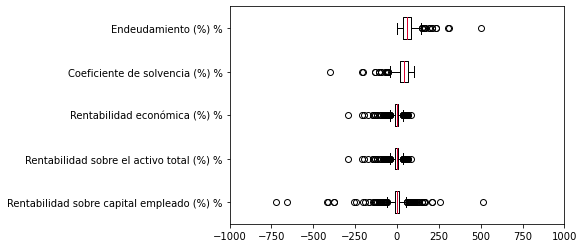

In [117]:
ax1 = df_numeric_sinna[columnas[:5]].plot(kind='box', color = 'black', vert= 0, flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='#d9002f'))

plt.xlim(-1000,1000)

plt.title('')
plt.show()

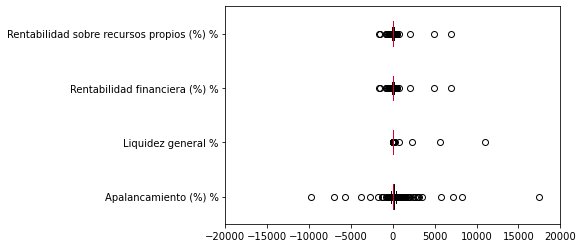

In [118]:
ax2 = df_numeric_sinna[columnas[5:9]].plot(kind='box', vert = 0, color = 'black', flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='#d9002f'))
plt.title('')
plt.xlim(-20000,20000)
plt.show()

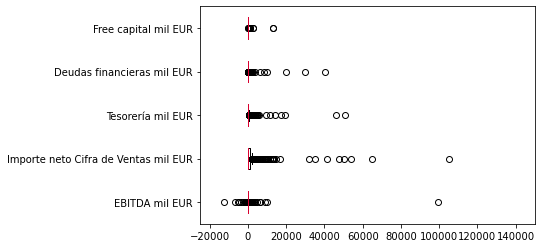

In [119]:
ax3 = df_numeric_sinna[columnas[10:15]].plot(kind='box', color = 'black', vert= 0, flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='#d9002f'))
plt.xlim(-25000,150000)

plt.show()

Text(20.625, 0.5, '')

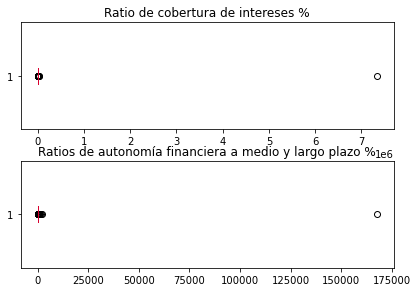

In [120]:
fig, ax4 = plt.subplots(2,1)
plt.tight_layout()
ax4[0].boxplot(df_numeric_sinna[columnas[15]][~np.isnan(df_numeric_sinna[columnas[15]])],
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='#d9002f'), vert=0)
ax4[0].set_title('Ratio de cobertura de intereses %')
ax4[0].set_xlabel('')

ax4[1].boxplot(df_numeric_sinna[columnas[16]][~np.isnan(df_numeric_sinna[columnas[16]])],
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='#d9002f'), vert =0)
ax4[1].set_title('Ratios de autonomía financiera a medio y largo plazo %')
ax4[1].set_ylabel('')

Text(0.5, 15.000000000000028, '')

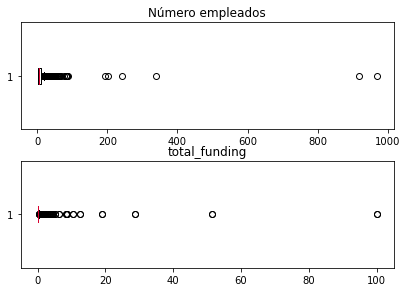

In [121]:
fig, ax5 = plt.subplots(2,1)
plt.tight_layout()

ax5[0].boxplot(df_numeric_sinna[columnas[17]][~np.isnan(df_numeric_sinna[columnas[17]])],
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='#d9002f'), vert =0)
ax5[0].set_title('Número empleados')
ax5[0].set_xlabel('')

ax5[1].boxplot(df_numeric_sinna[columnas[18]][~np.isnan(df_numeric_sinna[columnas[18]])],
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='#d9002f'), vert=0)
ax5[1].set_title('total_funding')
ax5[1].set_xlabel('')

Una vez hecho esto, se ha procedido a identificar las empresas consideradas outliers en cada variable (6 en la cola superior y 6 en la inferior):

In [122]:
saber_empresa_outliersMAX(dftot, columnas)

                                                  Nombre_sabi  \
Codigo_NIF                                                      
B01518620               GLOBETESTING NORTE SOCIEDAD LIMITADA.   
B01583350                         TITHONUS BIORESOURCES, S.L.   
A95991600     ENERGIA DISTRIBUIDA DEL NORTE SOCIEDAD ANONIMA.   
B75232918                                     TIDORE FOOD SL.   
B75232918                                     TIDORE FOOD SL.   
B95846713   MOTION AND CONTROL APLICACIONES SOCIEDAD LIMIT...   

            Rentabilidad sobre capital empleado (%) %    year  
Codigo_NIF                                                     
B01518620                                     515.686  2020.0  
B01583350                                     254.817  2020.0  
A95991600                                     210.267  2020.0  
B75232918                                     209.900  2021.0  
B75232918                                     166.808  2020.0  
B95846713                      

In [123]:
saber_empresa_outliersMIN(dftot, columnas)

                                                Nombre_sabi  \
Codigo_NIF                                                    
B01575679   HIPATIA CONTROL INTELIGENTE, SOCIEDAD LIMITADA.   
B95957643                              SAFYBOX DELIBERTY SL   
A95991600   ENERGIA DISTRIBUIDA DEL NORTE SOCIEDAD ANONIMA.   
B75124354             FUTBOLTEK TECHNOLOGY FOR TRAINING SL.   
B95957643                              SAFYBOX DELIBERTY SL   
B95969887             BERBA TRANSLATIONS SOCIEDAD LIMITADA.   

            Rentabilidad sobre capital empleado (%) %    year  
Codigo_NIF                                                     
B01575679                                    -724.311  2020.0  
B95957643                                    -659.283  2020.0  
A95991600                                    -418.812  2021.0  
B75124354                                    -412.170  2020.0  
B95957643                                    -374.825  2021.0  
B95969887                                    -3

---------------------------------------

## Capex y Free cash flow

In [124]:
# CÁLCULO DEL FREE CASH FLOW

# capex = activo no corriente año2 - (activo no corriente año1 - dotac.amort.año1)
#dftot['capex'] = dftot[dftot['year']==2021]['Inmovilizado mil EUR']-(dftot[dftot['year']==2020]['Inmovilizado mil EUR'] - dftot[dftot['year']==2020]['Dotaciones para amortiz. de inmovil. mil EUR'])

# free cash flow = ebit - impuestos + dotacion_amort - capex - activo circulante
# se corrigen capex y activo circulante porque están sumados pero aún no se han cobrado así que no son cash (clientes y proveedores)
#dftot['free_cash_flow'] = dftot['EBIT mil EUR'] - dftot['Impuestos sobre sociedades mil EUR'] + dftot['Dotaciones para amortiz. de inmovil. mil EUR'] \
#    - dftot['capex'] - dftot['Activo circulante mil EUR']

In [125]:
# Missings restantes
dftot.isna().sum()[dftot.isna().sum()>0] # solo quedan los de la target que hay que filtrar

valuation_2022    695
dtype: int64

# Feature selection

In [126]:
# features : según el modelo de Random Forest
# new_feat : según f_classif o f_regression
# new_features : según Recursive Feature Elimination
# corr_features : según correlación con la variable objetivo

In [127]:
df_aux = dftot.copy()

#### Para regresión

In [128]:
dftot = df_aux.copy()

In [129]:
dftot = dftot.drop(columns=['Codigo primario CNAE 2009', 'Nombre_sabi', 'Localidad', 'Fecha constitucion', 'Codigo consolidacion', 'Forma juridica', 'Forma juridica detallada', 'Estado', 'Estado detallado', 'website', 'name_dealroom', 'profile_url', 'tagline'])

In [130]:
# Se filtran los NaN de la target
dftot = dftot[~dftot['valuation_2022'].isna()]

In [131]:
X = dftot.drop(columns=['valuation_2022'])
y = dftot['valuation_2022']

In [132]:
X.shape # 120 instancias, 60 empresas

(120, 68)

In [133]:
# Label encoding sobre todas las categóricas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in X.select_dtypes(include='object').columns:
    X[col] = le.fit_transform(X[col])

In [134]:
# Split train-test
RANDOM_STATE = 42
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [135]:
# Modelo a partir del cual se sacarán las features más importantes
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)

['Existencias mil EUR',
 'Cash flow mil EUR',
 'Pasivo líquido mil EUR',
 'ratio_prueba_acida',
 'Número empleados',
 'ownerships',
 'Resultado del Ejercicio mil EUR',
 'ratio_deuda_patrimonio',
 'Acreedores comerciales mil EUR',
 'Inmovilizado mil EUR',
 'Activo circulante mil EUR',
 'Dotaciones para amortiz. de inmovil. mil EUR',
 'Deudas financieras mil EUR',
 'Resultado financiero mil EUR',
 'Importe neto Cifra de Ventas mil EUR',
 'ratio_ventas_patrimonio',
 'Tesorería mil EUR',
 'total_rounds',
 'Total pasivo y capital propio mil EUR',
 'ratio_ventas_activos',
 'Impuestos sobre sociedades mil EUR',
 'ratio_deuda_activos',
 'Total activo mil EUR',
 'Fondo de maniobra mil EUR']

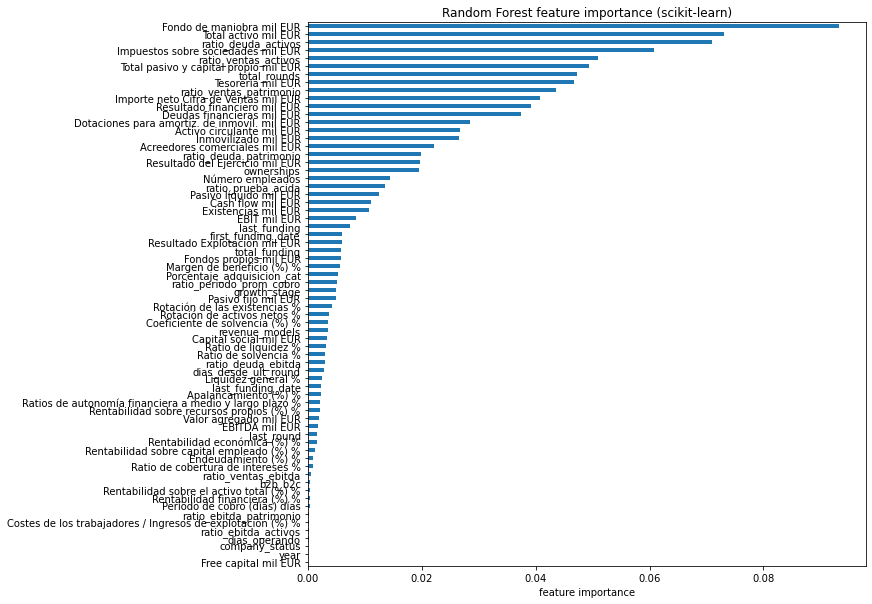

In [136]:
from matplotlib import pyplot as plt
forest_importances = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=True)
forest_importances

plt.figure(figsize=(10,10))
forest_importances.plot(kind='barh')
plt.xlabel("feature importance")
plt.title('Random Forest feature importance (scikit-learn)')

# Elegir esas variables
umbral = 0.01
forest_importances = forest_importances.to_frame().reset_index()
forest_importances.columns = ['feature', 'importance']
features = list(forest_importances[forest_importances['importance'] > umbral]['feature'])
features

In [137]:
# Según f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(f_regression, k=20)
selector = selector.fit(x_train, y_train)
mask = selector.get_support() # True si es importante, False si no lo es

new_feat = []
for bool, feature in zip(mask, x_train.columns):
    if bool:
        new_feat.append(feature)
print('The best features are:{}'.format(new_feat))

The best features are:['total_funding', 'last_funding', 'revenue_models', 'Número empleados', 'Inmovilizado mil EUR', 'Activo circulante mil EUR', 'Total activo mil EUR', 'Fondos propios mil EUR', 'Pasivo fijo mil EUR', 'Pasivo líquido mil EUR', 'Total pasivo y capital propio mil EUR', 'Resultado Explotación mil EUR', 'Resultado del Ejercicio mil EUR', 'Tesorería mil EUR', 'EBIT mil EUR', 'Fondo de maniobra mil EUR', 'Deudas financieras mil EUR', 'Importe neto Cifra de Ventas mil EUR', 'Existencias mil EUR', 'Acreedores comerciales mil EUR']


In [138]:
# Recursive feature elimination
from sklearn.feature_selection import RFE

rf_RFE = RandomForestRegressor(random_state=RANDOM_STATE)
selector = RFE(rf_RFE, n_features_to_select=20)
selector = selector.fit(x_train, y_train)
rfe_mask = selector.get_support()

new_features = []
for bool, feature in zip(rfe_mask, x_train.columns):
    if bool:
        new_features.append(feature)
print('The best features are:{}'.format(new_features))

The best features are:['total_rounds', 'ownerships', 'Número empleados', 'Inmovilizado mil EUR', 'Activo circulante mil EUR', 'Total activo mil EUR', 'Total pasivo y capital propio mil EUR', 'Resultado financiero mil EUR', 'Resultado del Ejercicio mil EUR', 'Tesorería mil EUR', 'Fondo de maniobra mil EUR', 'Impuestos sobre sociedades mil EUR', 'Dotaciones para amortiz. de inmovil. mil EUR', 'Deudas financieras mil EUR', 'Importe neto Cifra de Ventas mil EUR', 'Acreedores comerciales mil EUR', 'ratio_deuda_activos', 'ratio_deuda_patrimonio', 'ratio_ventas_activos', 'ratio_ventas_patrimonio']


In [139]:
# Variables más correlacionadas con la variable objetivo
corr = dftot.corr()
corr = corr.sort_values(by=['valuation_2022'], ascending=False)

# Top correlacionadas con la variable objetivo
corr_features = corr['valuation_2022'].head(20).index[1:]
corr.iloc[1:6, :]['valuation_2022']

Activo circulante mil EUR                0.573366
Fondo de maniobra mil EUR                0.566263
Tesorería mil EUR                        0.563689
Existencias mil EUR                      0.558500
Total pasivo y capital propio mil EUR    0.535204
Name: valuation_2022, dtype: float64

In [140]:
# Modelo base: predecir la variable objetivo con cada combinación de variables con un Random Forest

from sklearn.metrics import mean_squared_error, r2_score

def modelo_base(features):
    X = dftot[features]
    y = dftot['valuation_2022']
    for col in X.select_dtypes(include='object').columns:
        X.loc[:, col] = le.fit_transform(X.loc[:, col])
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
    rf = RandomForestRegressor(random_state=RANDOM_STATE)
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f'Este método tiene un RMSE de {rmse.round(4)}, un R2 de {r2.round(4)}')
    return r2

In [141]:
# Mejor modelo en base a R2
def mejor_modelo():
    modelos = [features, new_feat, new_features, corr_features, dftot.columns]
    r2 = []
    for modelo in modelos:
        r2.append(modelo_base(modelo))
    mejor_modelo = modelos[np.argmax(r2)]
    print(f'El mejor método es el {np.argmax(r2)+1}, con un R2 de {np.max(r2).round(4)}')
    return mejor_modelo

mejor_modelo()

C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\1127961073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col] = le.fit_transform(X.loc[:, col])


Este método tiene un RMSE de 24.4588, un R2 de 0.4776


C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\1127961073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col] = le.fit_transform(X.loc[:, col])


Este método tiene un RMSE de 21.4299, un R2 de 0.5989
Este método tiene un RMSE de 26.0194, un R2 de 0.4088


C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\1127961073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col] = le.fit_transform(X.loc[:, col])


Este método tiene un RMSE de 22.2404, un R2 de 0.568
Este método tiene un RMSE de 8.3102, un R2 de 0.9397
El mejor método es el 5, con un R2 de 0.9397


Index(['Capital social mil EUR', 'Free capital mil EUR',
       'Porcentaje_adquisicion_cat', 'total_funding', 'first_funding_date',
       'last_funding_date', 'last_funding', 'last_round', 'total_rounds',
       'ownerships', 'b2b_b2c', 'revenue_models', 'growth_stage',
       'company_status', 'valuation_2022', 'year', 'Número empleados',
       'Inmovilizado mil EUR', 'Activo circulante mil EUR',
       'Total activo mil EUR', 'Fondos propios mil EUR', 'Pasivo fijo mil EUR',
       'Pasivo líquido mil EUR', 'Total pasivo y capital propio mil EUR',
       'Resultado Explotación mil EUR', 'Resultado financiero mil EUR',
       'Resultado del Ejercicio mil EUR',
       'Costes de los trabajadores / Ingresos de explotación (%) %',
       'Tesorería mil EUR', 'Cash flow mil EUR',
       'Período de cobro (días) días', 'Valor agregado mil EUR',
       'Apalancamiento (%) %', 'Endeudamiento (%) %',
       'Margen de beneficio (%) %', 'Ratio de liquidez %',
       'Ratio de solvencia %', '

In [142]:
X = dftot[mejor_modelo()] # selecciona el mejor modelo
# Guardar X en path limpios
X.to_csv('Datos/Limpios/df_regr_prefusion.csv')

C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\1127961073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col] = le.fit_transform(X.loc[:, col])


Este método tiene un RMSE de 24.4588, un R2 de 0.4776


C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\1127961073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col] = le.fit_transform(X.loc[:, col])


Este método tiene un RMSE de 21.4299, un R2 de 0.5989


C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\1127961073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col] = le.fit_transform(X.loc[:, col])


Este método tiene un RMSE de 26.0194, un R2 de 0.4088
Este método tiene un RMSE de 22.2404, un R2 de 0.568
Este método tiene un RMSE de 8.3102, un R2 de 0.9397
El mejor método es el 5, con un R2 de 0.9397


#### Para clasificación

In [143]:
dftot = df_aux.copy()

In [144]:
dftot = dftot.drop(columns=['Codigo primario CNAE 2009', 'Nombre_sabi', 'Localidad', 'Fecha constitucion', 'Codigo consolidacion', 'Forma juridica', 'Forma juridica detallada', 'Estado', 'Estado detallado', 'website', 'name_dealroom', 'profile_url', 'tagline'])

In [145]:
dftot['Porcentaje_adquisicion_cat'].isna().sum() # no hay missings en la variable target

0

In [146]:
X = dftot.drop(columns=['Porcentaje_adquisicion_cat']).drop(columns=['valuation_2022'])
y = dftot['Porcentaje_adquisicion_cat']

In [147]:
# Label encoding sobre todas las categóricas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in X.select_dtypes(include='object').columns:
    X[col] = le.fit_transform(X[col])

In [148]:
# Split train-test
RANDOM_STATE = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [149]:
# Modelo a partir del cual se sacarán las features más importantes
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)

['ratio_prueba_acida',
 'Deudas financieras mil EUR',
 'Costes de los trabajadores / Ingresos de explotación (%) %',
 'ratio_ventas_activos',
 'last_funding_date',
 'total_funding',
 'Ratios de autonomía financiera a medio y largo plazo %',
 'dias_desde_ult_round',
 'Acreedores comerciales mil EUR',
 'EBITDA mil EUR',
 'Resultado financiero mil EUR',
 'Cash flow mil EUR',
 'Resultado Explotación mil EUR',
 'Existencias mil EUR',
 'EBIT mil EUR',
 'Importe neto Cifra de Ventas mil EUR',
 'Valor agregado mil EUR',
 'Período de cobro (días) días',
 'first_funding_date',
 'Activo circulante mil EUR',
 'Pasivo líquido mil EUR',
 'Impuestos sobre sociedades mil EUR',
 'Inmovilizado mil EUR',
 'dias_operando',
 'Total activo mil EUR',
 'Fondos propios mil EUR',
 'Capital social mil EUR',
 'Total pasivo y capital propio mil EUR',
 'Resultado del Ejercicio mil EUR',
 'Dotaciones para amortiz. de inmovil. mil EUR']

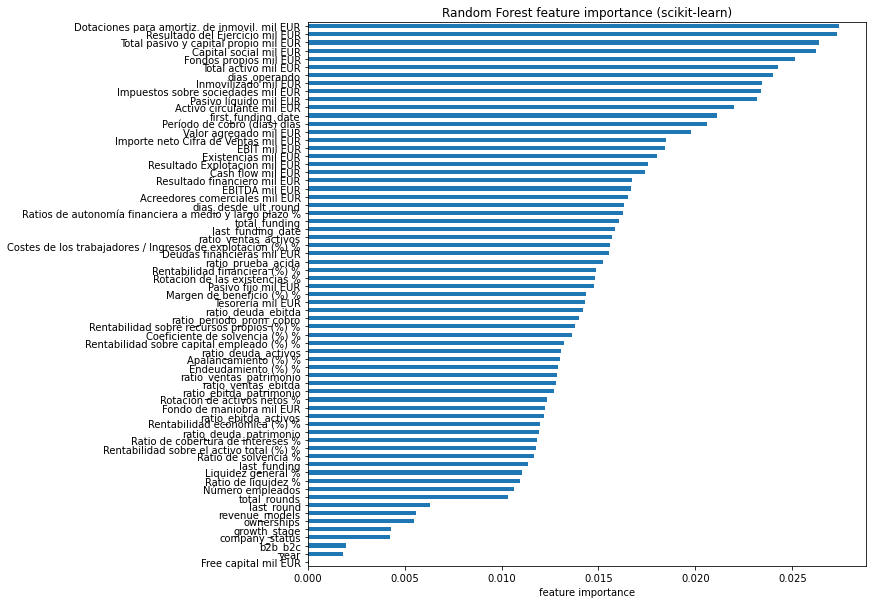

In [150]:
from matplotlib import pyplot as plt
forest_importances = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=True)
forest_importances

plt.figure(figsize=(10,10))
forest_importances.plot(kind='barh')
plt.xlabel("feature importance")
plt.title('Random Forest feature importance (scikit-learn)')

# Elegir esas variables
umbral = 0.015
forest_importances = forest_importances.to_frame().reset_index()
forest_importances.columns = ['feature', 'importance']
features = list(forest_importances[forest_importances['importance'] > umbral]['feature'])
features

In [151]:
# Según f_classif
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=20)
selector = selector.fit(x_train, y_train)
mask = selector.get_support() # True si es importante, False si no lo es

new_feat = []
for bool, feature in zip(mask, x_train.columns):
    if bool:
        new_feat.append(feature)
print('The best features are:{}'.format(new_feat))

The best features are:['total_funding', 'first_funding_date', 'last_funding_date', 'ownerships', 'revenue_models', 'growth_stage', 'company_status', 'Número empleados', 'Inmovilizado mil EUR', 'Fondos propios mil EUR', 'Tesorería mil EUR', 'Valor agregado mil EUR', 'Margen de beneficio (%) %', 'Rentabilidad sobre capital empleado (%) %', 'Dotaciones para amortiz. de inmovil. mil EUR', 'Importe neto Cifra de Ventas mil EUR', 'Existencias mil EUR', 'ratio_periodo_prom_cobro', 'dias_operando', 'dias_desde_ult_round']


In [152]:
# Recursive feature elimination
from sklearn.feature_selection import RFE

rf_RFE = RandomForestClassifier(random_state=RANDOM_STATE)
selector = RFE(rf_RFE, n_features_to_select=20)
selector = selector.fit(x_train, y_train)
rfe_mask = selector.get_support()

new_features = []
for bool, feature in zip(rfe_mask, x_train.columns):
    if bool:
        new_features.append(feature)
print('The best features are:{}'.format(new_features))

The best features are:['Capital social mil EUR', 'total_funding', 'first_funding_date', 'Inmovilizado mil EUR', 'Total activo mil EUR', 'Fondos propios mil EUR', 'Pasivo líquido mil EUR', 'Total pasivo y capital propio mil EUR', 'Resultado del Ejercicio mil EUR', 'Cash flow mil EUR', 'Período de cobro (días) días', 'Valor agregado mil EUR', 'EBIT mil EUR', 'Impuestos sobre sociedades mil EUR', 'Dotaciones para amortiz. de inmovil. mil EUR', 'Acreedores comerciales mil EUR', 'ratio_ebitda_patrimonio', 'ratio_ventas_activos', 'ratio_prueba_acida', 'dias_operando']


In [153]:
# Variables más correlacionadas con la variable objetivo
corr = dftot.corr()
corr = corr.sort_values(by=['Porcentaje_adquisicion_cat'], ascending=False)

# Top 30 más correlacionadas con la variable objetivo
corr_features = corr['Porcentaje_adquisicion_cat'].head(20).index[1:]
corr.iloc[1:6, :]['Porcentaje_adquisicion_cat']

dias_operando                                   0.169033
Inmovilizado mil EUR                            0.148104
Dotaciones para amortiz. de inmovil. mil EUR    0.142771
Fondos propios mil EUR                          0.142676
Número empleados                                0.130916
Name: Porcentaje_adquisicion_cat, dtype: float64

In [154]:
# Modelo base: predecir la variable objetivo con cada combinación de variables con un Random Forest

from sklearn.metrics import accuracy_score

def modelo_base(features):
    X = dftot[features]
    try:
        X = X.drop(columns=['valuation_2022'])
    except:
        pass
    y = dftot['Porcentaje_adquisicion_cat']
    for col in X.select_dtypes(include='object').columns:
        X[col] = le.fit_transform(X[col])
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
    rf = RandomForestClassifier(random_state=RANDOM_STATE)
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Este método tiene un accuracy de {accuracy.round(4)}')
    return accuracy

In [155]:
# Mejor modelo en base a accuracy
def mejor_modelo():
    modelos = [features, new_feat, new_features, corr_features, dftot.columns]
    accuracy = []
    for modelo in modelos:
        accuracy.append(modelo_base(modelo))
    mejor_modelo = modelos[np.argmax(accuracy)]
    print(f'El mejor método es el {np.argmax(accuracy)+1}, con un accuracy de {np.max(accuracy).round(4)}')
    return mejor_modelo

In [156]:
from sklearn.metrics import confusion_matrix
X = dftot[mejor_modelo()] # selecciona el mejor modelo
# Guardar X en path limpios
X.to_csv('Datos/Limpios/df_clasif_prefusion.csv')

try:
    X = X.drop(columns=['valuation_2022'])
except:
    pass
y = dftot['Porcentaje_adquisicion_cat']
for col in X.select_dtypes(include='object').columns:
    X[col] = le.fit_transform(X[col])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)

print(rf.__class__.__name__, ':', round(accuracy_score(y_test, predictions),4), '\n', confusion_matrix(y_test, predictions))

C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\454778818.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


Este método tiene un accuracy de 0.6857


C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\454778818.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


Este método tiene un accuracy de 0.7061


C:\Users\usuario\AppData\Local\Temp\ipykernel_9680\454778818.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


Este método tiene un accuracy de 0.649
Este método tiene un accuracy de 0.6857
Este método tiene un accuracy de 0.9633
El mejor método es el 5, con un accuracy de 0.9633
RandomForestClassifier : 0.9633 
 [[ 85   0   0]
 [  0 105   0]
 [  0   9  46]]


### Actualización de datos

In [157]:
df = dftot.copy() # ninguna selección de variables se acerca al error o al accuracy del modelo con todas las variables

In [158]:
df.shape

(815, 69)

In [159]:
df.isna().sum().sort_values(ascending=False)

valuation_2022                                  695
Capital social mil EUR                            0
Dotaciones para amortiz. de inmovil. mil EUR      0
Fondo de maniobra mil EUR                         0
EBIT mil EUR                                      0
                                               ... 
Cash flow mil EUR                                 0
Período de cobro (días) días                      0
Valor agregado mil EUR                            0
Apalancamiento (%) %                              0
dias_desde_ult_round                              0
Length: 69, dtype: int64

---------------------------------------

# Normalización de los datos

#### Opción A: datos sin normalizar

In [160]:
dfa_1 = pd.read_csv(os.path.join(path_clean_data,'df_regr_prefusion.csv'))
dfa_2 = pd.read_csv(os.path.join(path_clean_data,'df_clasif_prefusion.csv'))
dfa_1.describe()

,Capital social mil EUR,Free capital mil EUR,Porcentaje_adquisicion_cat,total_funding,last_funding,total_rounds,valuation_2022,year,Número empleados,Inmovilizado mil EUR,...,ratio_deuda_patrimonio,ratio_ebitda_activos,ratio_ebitda_patrimonio,ratio_ventas_ebitda,ratio_ventas_activos,ratio_ventas_patrimonio,ratio_prueba_acida,ratio_periodo_prom_cobro,dias_operando,dias_desde_ult_round
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,1080.957302,14.509833,0.966667,3.051667,0.978516,6.183333,14.866000,2020.500000,12.546349,2201.319088,...,0.246016,-0.057863,-0.022335,-1.899950,0.298516,0.887430,343.062967,310.357043,2578.800000,1768.683333
std,4508.571623,111.919451,0.483915,7.878575,3.667168,3.015320,31.175687,0.502096,15.611746,4108.896185,...,1.091165,0.185696,0.694643,23.688858,0.354464,1.833388,723.595321,597.360441,1128.767988,5679.778376
min,3.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090000,2020.000000,1.000000,7.898090,...,-1.630018,-1.168613,-2.032186,-168.308046,0.000762,-4.808179,0.102355,0.021586,964.000000,465.000000
25%,10.441500,0.000000,1.000000,0.150000,0.030000,4.000000,1.267500,2020.000000,4.000000,187.038498,...,0.018831,-0.119168,-0.228443,-2.212861,0.026318,0.040554,2.209123,21.357763,1740.750000,679.000000
50%,43.413000,0.000000,1.000000,0.510000,0.137955,5.500000,4.460000,2020.500000,8.000000,807.762255,...,0.048664,-0.044950,-0.056522,-0.115517,0.175411,0.319212,5.323821,62.178951,2329.500000,845.000000
75%,332.546587,0.000000,1.000000,1.865000,0.310961,8.000000,10.855000,2021.000000,16.250000,2149.146710,...,0.163966,0.027619,0.075817,2.349964,0.402548,1.210329,468.330611,239.279810,3232.000000,1165.000000
max,34676.056000,870.590000,2.000000,51.350000,27.270000,17.000000,156.400000,2021.000000,89.000000,25584.340150,...,11.381294,0.525883,4.388859,76.694612,1.713815,13.659018,5561.375668,4037.221354,5448.000000,44994.000000


#### Opción B: (x - mean)/std

In [161]:
# (x - mean(x)) / std(x) por cada columna numérica, y se mantiene el valor de 2021 para las variables categóricas
dfb = df.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in dfb.select_dtypes(include='number').columns:
    if col != 'Porcentaje_adquisicion_cat' or col != 'valuation_2022':
        pass
    dfb[col] = scaler.fit_transform(dfb[col].values.reshape(-1, 1))

dfb.shape

(815, 69)

#### Opción C: (x - min)/(max - min)

In [162]:
# (x - min(x)) / (max(x) - min(x)) por cada columna numérica, y se mantiene el valor de 2021 para las variables categóricas
dfc = df.copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for col in dfc.select_dtypes(include='number').columns:
    if col != 'Porcentaje_adquisicion_cat' or col != 'valuation_2022':
        pass
    dfc[col] = scaler.fit_transform(dfc[col].values.reshape(-1, 1))

dfc.shape

(815, 69)

#### Mejor opción para regresión

In [163]:
def random_forest_regr(df):
    """Calcula el RMSE de un modelo de Random Forest Regressor básico. Sirve para comparar conjuntos de datos.
    Args:
        df (pandas.dataframe): dataframe con las variables predictoras y la variable objetivo, la cual debe llamarse 'valuation 2022'.

    Returns:
        mape: error absoluto porcentual medio del modelo entrenado de Random Forest Regressor.
    """
    df = df.dropna(subset=['valuation_2022']) # filtramos las filas con valores nulos en la variable objetivo
    try:
        df = df.drop(columns=['first_funding_date', 'last_funding_date'])
    except:
        pass
    X = df.drop('valuation_2022', axis=1)
    y = df['valuation_2022']

    # Label encoding
    for col in X.select_dtypes(include='object').columns:
        X[col] = le.fit_transform(X[col])
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf = RandomForestRegressor(random_state=RANDOM_STATE)
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    r2 = r2_score(y_test, predictions)

    return r2

In [164]:
# Probar Random Forest con las tres opciones

# Opción A: sin escalar

print(f'Sin escalar: {random_forest_regr(dfa_1).round(4)} de R2')

# Opción B: con StandardScaler
print(f'Con StandardScaler: {random_forest_regr(dfb).round(4)} de R2')

# Opción C: con MinMaxScaler
print(f'Con MinMaxScaler: {random_forest_regr(dfc).round(4)} de R2')

print(f'El mejor modelo es el de la opción {np.argmax([random_forest_regr(dfa_1), random_forest_regr(dfb), random_forest_regr(dfc)]) + 1} con un R2 de {(np.max([random_forest_regr(dfa_1), random_forest_regr(dfb), random_forest_regr(dfc)])).round(4)}')

Sin escalar: 0.4796 de R2
Con StandardScaler: 0.4769 de R2
Con MinMaxScaler: 0.4346 de R2
El mejor modelo es el de la opción 1 con un R2 de 0.4796


#### Mejor opción para clasificación

In [165]:
from sklearn.metrics import accuracy_score

def random_forest_clasif(df):
    """Calcula el accuracy de un modelo de Random Forest Classifier básico. Sirve para comparar conjuntos de datos.
    Args:
        df (pandas.dataframe): dataframe con las variables predictoras y la variable objetivo, la cual debe llamarse 'Porcentaje_adquisicion_cat'.

    Returns:
        accuracy: accuracy del modelo entrenado de Random Forest Classifier.
    """
    try:
        df = df.drop(columns=['first_funding_date', 'last_funding_date', 'valuation_2022'])
    except:
        pass
    X = df.drop('Porcentaje_adquisicion_cat', axis=1)
    y = df['Porcentaje_adquisicion_cat'].astype('int')
    
    # Label encoding
    for col in X.select_dtypes(include='object').columns:
        X[col] = le.fit_transform(X[col])
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    rf = RandomForestClassifier(random_state=RANDOM_STATE)
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    accuracy = accuracy_score(y_test, predictions).round(4)
    #print(rf.__class__.__name__, ':', round(accuracy_score(y_test, predictions),4), '\n', confusion_matrix(y_test, predictions))

    return accuracy

In [166]:
# Probar Random Forest con las tres opciones

# Opción A: sin escalar

print(f'Sin escalar: {random_forest_clasif(dfa_1)} de accuracy')

# Opción B: con StandardScaler
print(f'Con StandardScaler: {random_forest_clasif(dfb)} de accuracy')

# Opción C: con MinMaxScaler
print(f'Con MinMaxScaler: {random_forest_clasif(dfc)} de accuracy')

print(f'El mejor modelo es el de la opción {np.argmax([random_forest_clasif(dfa_1), random_forest_clasif(dfb), random_forest_clasif(dfc)]) + 1} con un accuracy de {(np.max([random_forest_clasif(dfa_1), random_forest_clasif(dfb), random_forest_clasif(dfc)])).round(4)}')

Sin escalar: 0.8056 de accuracy
Con StandardScaler: 0.649 de accuracy
Con MinMaxScaler: 0.8 de accuracy
El mejor modelo es el de la opción 1 con un accuracy de 0.8056


In [167]:
# Para ambos casos el mejor método no escalar
df = dfa_2.copy()
df.shape

(815, 70)

---------------------------------------

# Fusión de los años 2020 y 2021

Iteraremos sobre los datos tratando las filas a pares. Crearemos una función que comprueba que la combinación de las dos instancias próximas es 2021 primero y 2020 después. Si eso es así, otra función calculará (2021-2020)/2020*100 para cada variable, y esa fila que representa la diferencia entre los años se añadirá al nuevo dataframe.

Si la comprobación de la combinación de 2021 primero y 2020 después falla, se imprimirá un error por pantalla y se ignorará ese par de filas.

De esta manera, se reduce el número de instancias a la mitad: 60 instancias para 60 empresas, teniendo una fila por empresa.

In [168]:
df_aux = df.copy()

In [169]:
# Se añade la columna del año
df2_reset = df2.reset_index()
df_year = df2_reset['year']
df_aux.reset_index(inplace=True)
df = pd.concat([df_aux, df_year], axis=1)
df.columns = df_aux.columns.tolist() + ['year']

In [170]:
df = df.loc[:,~df.columns.duplicated()] # si hay columnas duplicadas, se elimina una de ellas

In [171]:
# Ignore funding dates
df = df.drop(columns=['first_funding_date', 'last_funding_date'])
df['Porcentaje_adquisicion_cat'] = df['Porcentaje_adquisicion_cat'].astype('object')

In [172]:
def is_valid_pair(row1, row2):
    """Función que comprueba si un par de filas cumple las condiciones.

    Parameters:
    -----------
    row1 : pandas Series
        La primera fila a comparar.
    row2 : pandas Series
        La segunda fila a comparar.

    Returns:
    --------
    bool
        True si el par de filas cumple las condiciones, False en caso contrario.
    """
    return row1['year'] == 2021 and row2['year'] == 2020


def get_difference(row1, row2):
    """Función que calcula la diferencia porcentual entre dos filas.

    Parameters:
    -----------
    row1 : pandas Series
        La primera fila a comparar.
    row2 : pandas Series
        La segunda fila a comparar.

    Returns:
    --------
    dict
        Un diccionario con las diferencias calculadas. Las variables
        categóricas mantienen el valor de la primera fila.
    """
    difference = {}
    for col in row1.index:
        if isinstance(row1[col], str) or col == 'valuation_2022' or col == 'Porcentaje_adquisicion_cat':
            # Si la columna es de tipo string o es una de las variables target, mantener el valor de la fila de 2021
            difference[col] = row1[col]
        else:
            # Si la columna es numérica, calcular la diferencia porcentual, salvo que el valor de la fila de 2020 sea 0
            if row2[col] == 0:
                difference[col] = 0
            else:
                difference[col] = (row1[col] - row2[col]) / row2[col] * 100
    return difference


def calculate_differences(df):
    """Función que itera sobre un DataFrame y calcula las diferencias.

    Parameters:
    -----------
    df : pandas DataFrame
        El DataFrame que contiene los datos.

    Returns:
    --------
    pandas DataFrame
        Un nuevo DataFrame con las diferencias calculadas.
    """
    differences = []
    for i in range(len(df) - 1):
        if is_valid_pair(df.iloc[i], df.iloc[i + 1]):
            differences.append(get_difference(df.iloc[i], df.iloc[i + 1]))
    return pd.DataFrame(differences)

In [173]:
df.head(6) # antes de aplicar la función loop

,index,Codigo_NIF,Capital social mil EUR,Free capital mil EUR,Porcentaje_adquisicion_cat,total_funding,last_funding,last_round,total_rounds,ownerships,...,ratio_deuda_patrimonio,ratio_ebitda_activos,ratio_ebitda_patrimonio,ratio_ventas_ebitda,ratio_ventas_activos,ratio_ventas_patrimonio,ratio_prueba_acida,ratio_periodo_prom_cobro,dias_operando,dias_desde_ult_round
0,0,A78053147,2000.0,0.0,2,0.00000,0.000000,sin ronda,0,bootstrapped,...,0.299961,0.005223,0.042148,203.551925,1.063168,8.579402,656.482384,98.599699,13793,44994
1,1,A78053147,2000.0,0.0,2,0.00000,0.000000,sin ronda,0,bootstrapped,...,0.162420,0.095601,0.680009,9.819650,0.938765,6.677451,513.465916,130.058609,13793,44994
2,2,B75103515,20500.0,0.0,1,0.86575,0.728037,SUPPORT PROGRAM,1,accelerator,...,3.730236,-0.030085,-0.629786,-20.922413,0.629449,13.176632,1.200000,69.456993,3336,3356
3,3,B75103515,20500.0,0.0,1,0.86575,0.728037,SUPPORT PROGRAM,1,accelerator,...,-1.152470,-0.101442,0.717084,-4.026778,0.408485,-2.887537,1.106586,91.696964,3336,3356
4,4,B95864310,7515.0,0.0,1,0.00000,0.000000,sin ronda,0,accelerator,...,0.365205,0.019084,0.086028,32.930598,0.628438,2.832956,0.209598,66.930236,2297,44994
5,5,B95864310,7515.0,0.0,1,0.00000,0.000000,sin ronda,0,accelerator,...,0.580171,-0.047186,-0.204820,-11.625769,0.548570,2.381190,0.286003,187.821838,2297,44994


In [174]:
df_diff = calculate_differences(df)
df_diff.head(3) # después de aplicar la función loop

,index,Codigo_NIF,Capital social mil EUR,Free capital mil EUR,Porcentaje_adquisicion_cat,total_funding,last_funding,last_round,total_rounds,ownerships,...,ratio_deuda_patrimonio,ratio_ebitda_activos,ratio_ebitda_patrimonio,ratio_ventas_ebitda,ratio_ventas_activos,ratio_ventas_patrimonio,ratio_prueba_acida,ratio_periodo_prom_cobro,dias_operando,dias_desde_ult_round
0,-100.000000,A78053147,0.0,0.0,2,0.0,0.0,sin ronda,0.0,bootstrapped,...,84.682330,-94.536564,-93.801778,1972.903974,13.251777,28.483180,27.853157,-24.188256,0.0,0.0
1,-33.333333,B75103515,0.0,0.0,1,0.0,0.0,SUPPORT PROGRAM,0.0,accelerator,...,-423.673144,-70.342819,-187.825931,419.581942,54.093356,-556.327677,8.441659,-24.253770,0.0,0.0
2,-20.000000,B95864310,0.0,0.0,1,0.0,0.0,sin ronda,0.0,accelerator,...,-37.052089,-140.443814,-142.001797,-383.255232,14.559218,18.972286,-26.714724,-64.365040,0.0,0.0


In [175]:
# La columna 'year' ya no es necesaria, ya que todas las filas indican la diferencia entre dos años
df_diff = df_diff.drop(columns=['year'])

In [176]:
df_diff.set_index('Codigo_NIF', inplace=True)

#### ¿Mejora los resultados para regresión?

In [177]:
df_regr = df_diff.drop(columns=['Porcentaje_adquisicion_cat'])
df_regr = df_diff.dropna(subset=['valuation_2022'])
df_regr.shape # 60 instancias, 60 empresas

(60, 67)

In [178]:
# Random Forest Regressor con los datos obtenidos de las diferencias porcentuales de 2020 a 2021 (la segunda derivada)
print(f'Con la segunda derivada (la diferencia porcentual de 2020 a 2021): {random_forest_regr(df_regr).round(4)} de R2')

Con la segunda derivada (la diferencia porcentual de 2020 a 2021): -0.0411 de R2


#### ¿Mejora los resultados para clasificación?

In [179]:
df_clasif = df_diff.drop(columns=['valuation_2022'])
df_clasif.shape

(403, 66)

In [180]:
# Random Forest Classifier con los datos obtenidos de las diferencias porcentuales de 2020 a 2021 (la segunda derivada)
print(f'Con la segunda derivada (la diferencia porcentual de 2020 a 2021): {random_forest_clasif(df_clasif)} de accuracy')

Con la segunda derivada (la diferencia porcentual de 2020 a 2021): 0.4876 de accuracy


---------------------------------------

# Datos para clasificación (predecir adquisición)

In [181]:
df_clasif['Porcentaje_adquisicion_cat'].value_counts()

1    164
0    160
2     79
Name: Porcentaje_adquisicion_cat, dtype: int64

In [182]:
df_clasif.shape

(403, 66)

In [183]:
df_clasif.reset_index(inplace=True)

# Datos para regresión (predecir valoración)

Filtrado de instancias

In [184]:
df_regr.shape # 60 instancias = 60 empresas

(60, 67)

In [185]:
df_regr['valuation_2022'].isna().sum()

0

<AxesSubplot:>

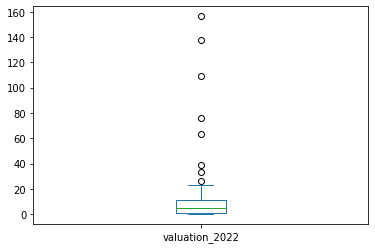

In [186]:
df_regr['valuation_2022'].plot(kind='box')

In [187]:
df_regr.reset_index(inplace=True)

-----------------

# GUARDAR DATOS LIMPIOS

#### Creación de directorios

In [188]:
# Se crea el directorio donde se guardarán los modelos
path_modelos = os.path.join('Modelos')
if not os.path.exists(path_modelos):
    os.makedirs(path_modelos)

In [189]:
# Se crea el directorio donde se guardarán los gráficos
path_graficos = os.path.join('Graficos')
if not os.path.exists(path_graficos):
    os.makedirs(path_graficos)

#### Guardado del dataframe para clasificación

In [190]:
# Se guarda el dataset limpio
file_clean = os.path.join(path_clean_data,'df_clasif.csv') # nombre con el que se guardará el archivo
df_clasif.to_csv(file_clean, index = False) # nombre del df a guardar con el método que incluye el path
print(f"{df_clasif['Codigo_NIF'].nunique()} startups en los datos limpios para clasificación.")
print(f"{df_clasif.shape[1]} variables en el dataframe limpio guardado para clasificación.")

403 startups en los datos limpios para clasificación.
67 variables en el dataframe limpio guardado para clasificación.


#### Guardado del dataframe para regresión

In [192]:
# Se guarda el dataset limpio
file_clean = os.path.join(path_clean_data,'df_regr.csv') # nombre con el que se guardará el archivo
df_regr.to_csv(file_clean, index = False) # nombre del df a guardar con el método que incluye el path
print(f"{df_regr['Codigo_NIF'].nunique()} startups en los datos limpios para regresión.")
print(f"{df_regr.shape[1]} variables en el dataframe limpio guardado para regresión.")

60 startups en los datos limpios para regresión.
68 variables en el dataframe limpio guardado para regresión.
